<div style="text-align:center"> 
    <p style="font-size: 50px; margin-bottom: 0">Chemical Cartography</p>
    <p style="font-size: 20px; font-style: italic">ASTR 511 HW3 - Tom Wagg</p>
    <p>(glad we're continuing the theme of c alliteration in these titles haha)</p>
</div>

In [301]:
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support
quantity_support()

import numpy as np

import pandas as pd
pd.options.display.max_columns = None

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("dark_background")

from gala.dynamics import PhaseSpacePosition
from gala.potential.potential import MilkyWayPotential

from scipy.stats import norm
from scipy.optimize import curve_fit

%config InlineBackend.figure_format = "retina"

# Part 1

## 1.1: The Data

In [4]:
dat = Table.read('allStarLite-dr17-synspec_rev1.fits', format='fits', hdu=1)

In [5]:
f'In this dataset there {len(dat)} stars each with {len(dat.columns)} columns - some of which are themselves multidimensional!!'

'In this dataset there 733901 stars each with 191 columns - some of which are themselves multidimensional!!'

My approximate reaction to this:
![](danger.gif) (plug marvelling too of course)

In [302]:
# drop the multidimensional columns, switch to Pandas because why not and drop the NaNs/flagged stars
names = [name for name in dat.colnames if len(dat[name].shape) <= 1]
df = dat[names].to_pandas()
df = df.dropna(subset=["ALPHA_M", "FE_H", "AL_FE", "MG_FE", "MN_FE", "RA", "DEC", "GAIAEDR3_R_MED_GEO",
                       "GAIAEDR3_PMRA", "GAIAEDR3_PMDEC", "GAIAEDR3_DR2_RADIAL_VELOCITY"])
df = df[df["STARFLAG"] == 0]

In [312]:
f'That still leaves us with {len(df)} stars!'

'That still leaves us with 179352 stars!'

## 1.2: Wallerstein-Tinsley Diagram

Now let's plot our favourite new diagram. But first, here are some simple polygons that cover the two discs, I just did these roughly by eye when looking at the plots.

In [310]:
low_alpha_path = mpl.path.Path(
    np.array([
        [-0.5, 0.15],
        [-0.6, 0.15],
        [-0.8, 0.1],
        [-0.7, 0.05],
        [-0.6, 0.03],
        [0, -0.07],
        [0.55, -0.07],
        [0.58, 0.05],
        [0.2, 0.05],
        [-0.5, 0.15]
    ])
)
high_alpha_path = mpl.path.Path(
    np.array([
        [0.4, 0.05],
        [0.2, 0.05],
        [-0.5, 0.15],
        [-1, 0.23],
        [-1.3, 0.28],
        [-1.3, 0.35],
        [-0.25, 0.36],
        [0.4, 0.05]
    ])
)

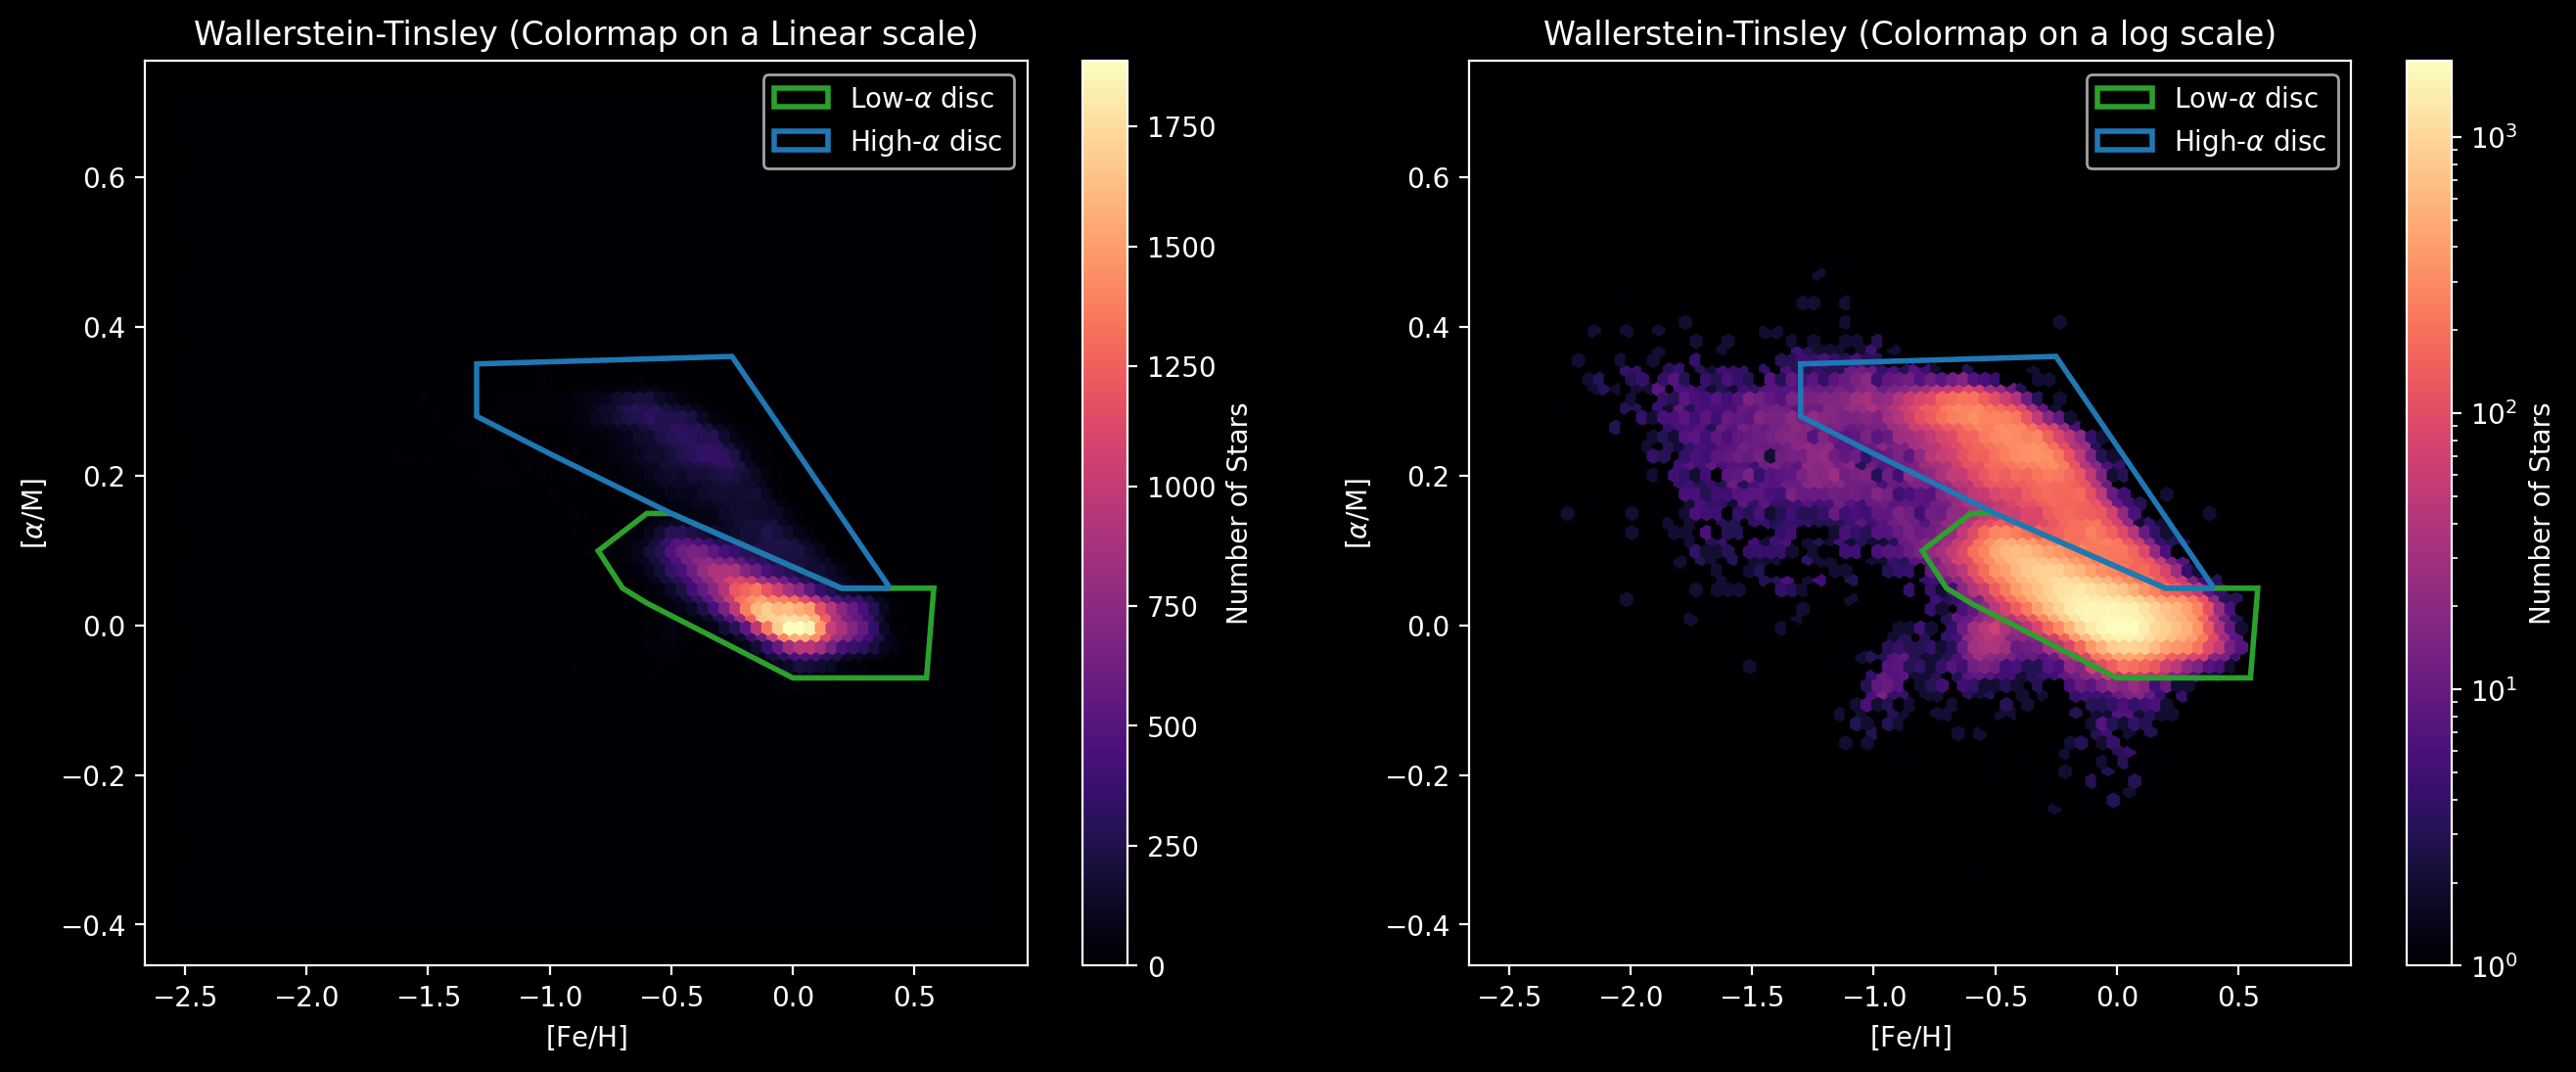

In [306]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, scale in zip(axes, [None, "log"]):
    hexbin = ax.hexbin(df["FE_H"], df["ALPHA_M"], cmap="magma", bins=scale, gridsize=75,
                       extent=(-2.5, 0.8, -0.4, 0.7))

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                   ["tab:green", "tab:blue"],
                                   [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    fig.colorbar(hexbin, label="Number of Stars", ax=ax)

    if scale is None:
        scale = "Linear"
    ax.set_title(f"Wallerstein-Tinsley (Colormap on a {scale} scale)")

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.legend()

plt.show()


We can see the two disc populations emerge very clearly (my cuts getting rid of things without proper motion seem to reduce the high-alpha disc a little unfortunately). In the log-scaled version we can see some other stuff going on at lower $\alpha$ values than the thin disc (no idea what these spikes and clusters of stars are!) and also some extension to lower metallicity in general that probably includes some halo stars.

## 1.3: Dwarfs vs. Giants (Davids  vs. Goliaths??)

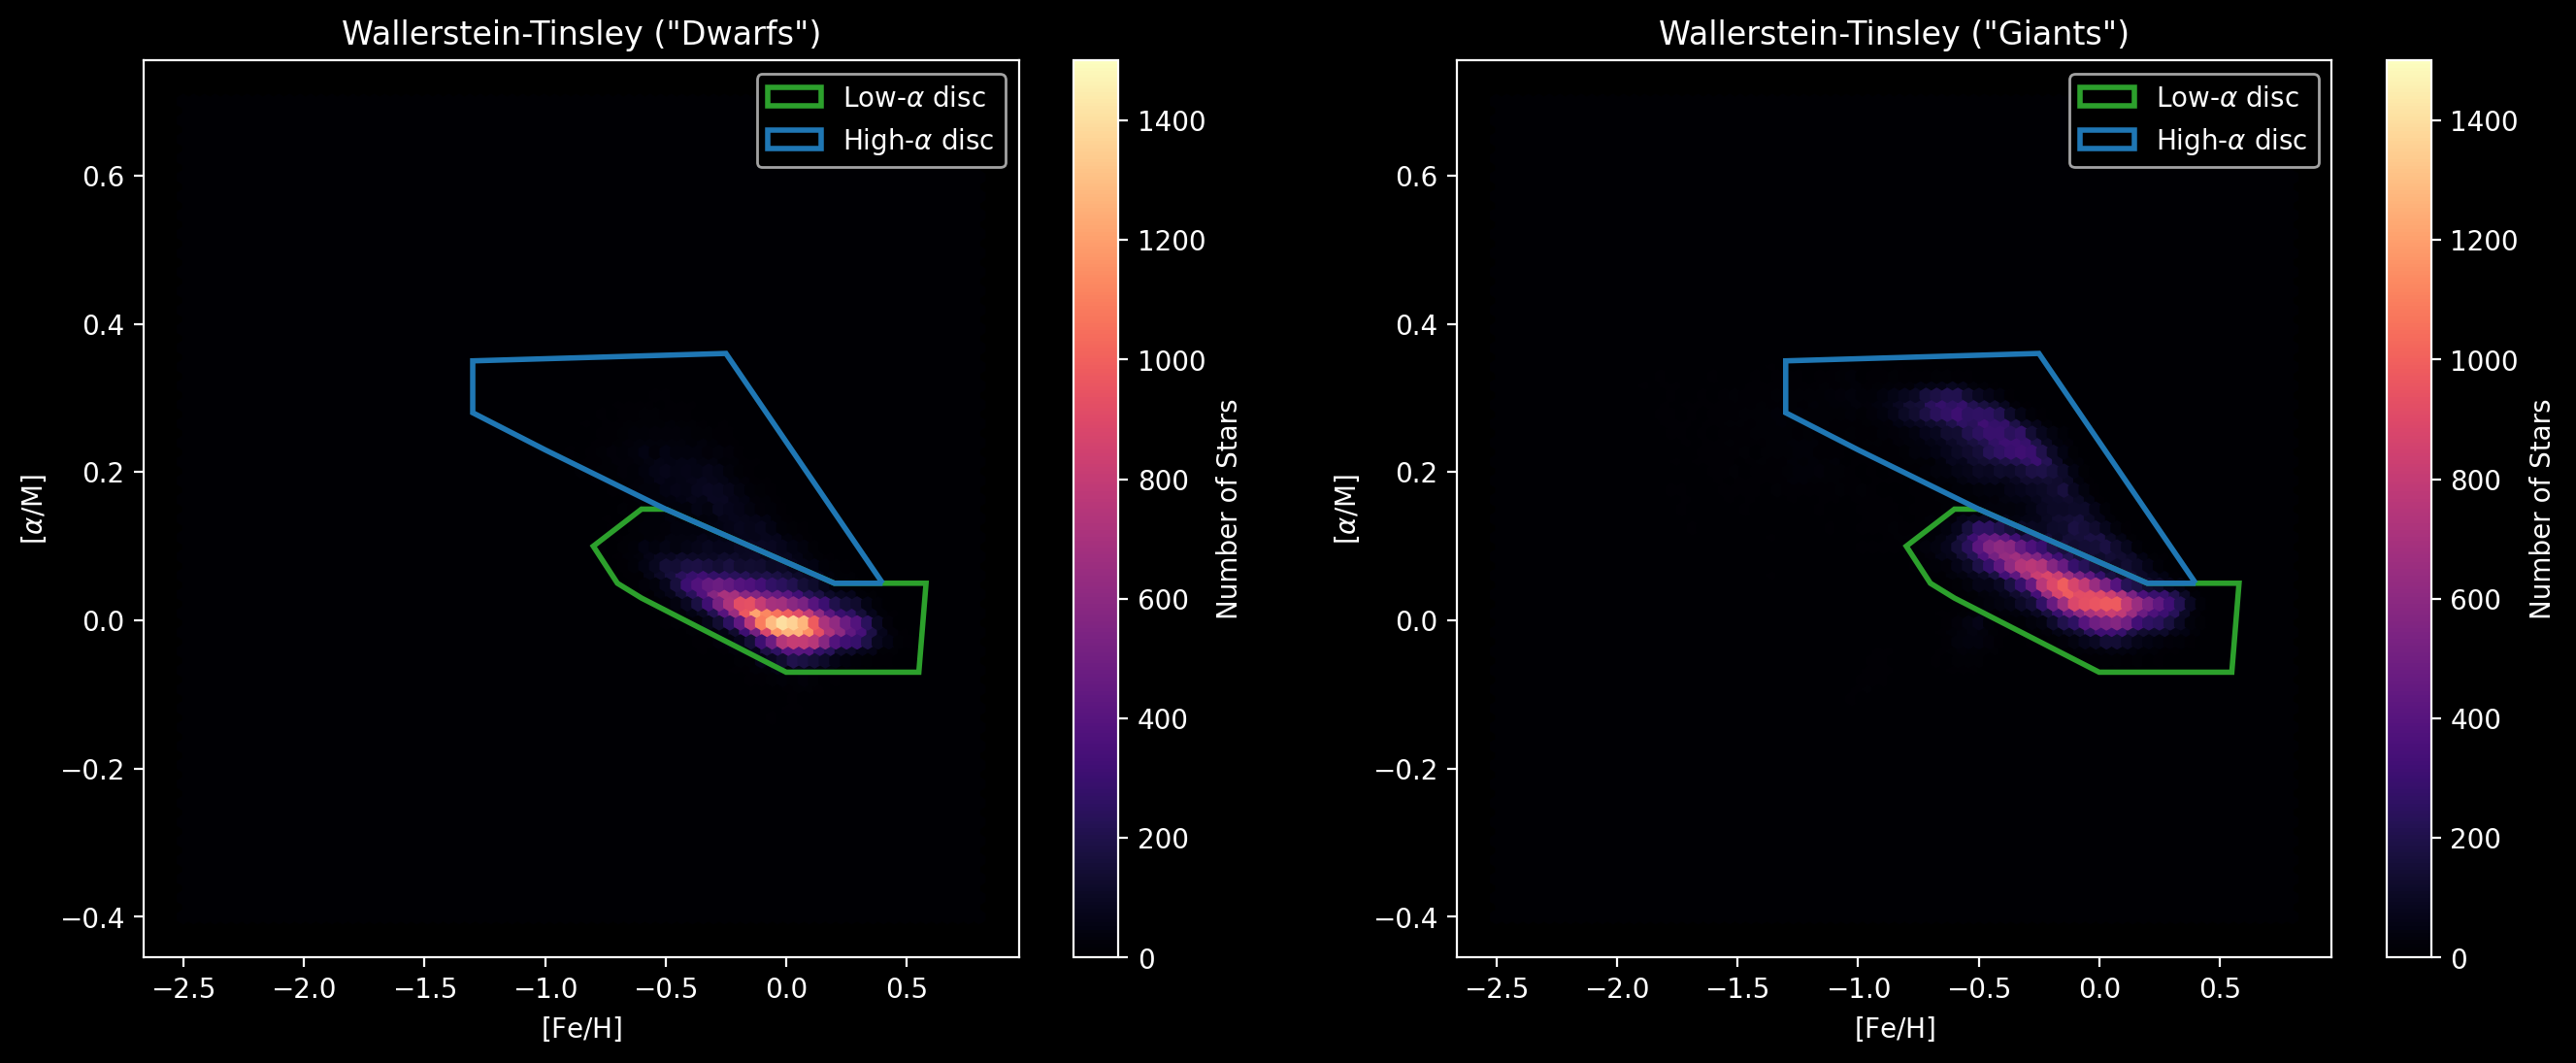

In [315]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

dwarfs, giants = (df["LOGG"] >= 3.5), (df["LOGG"] < 3.5)

for ax, mask, title in zip(axes, [dwarfs, giants], ["Dwarfs", "Giants"]):
    hexbin = ax.hexbin(df["FE_H"][mask], df["ALPHA_M"][mask], cmap="magma", bins=None, gridsize=75,
                       extent=(-2.5, 0.8, -0.4, 0.7), vmax=1500)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                   ["tab:green", "tab:blue"],
                                   [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    fig.colorbar(hexbin, label="Number of Stars", ax=ax)

    if scale is None:
        scale = "Linear"
    ax.set_title(f'Wallerstein-Tinsley (\"{title}\")')

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.legend()

plt.show()


So it looks to me like both discs are present for the Giants, but we can only see thin disc for the Dwarfs! However the thin-disc is more prominent for the dwarfs. So it seems that doing this split can help us track each of the discs with each population!

# Part Two

Now let's look at how thing are distributed _physically_!

## 2.1: Scale heights

### Go galactocentric and mask masks

First we can create a SkyCoord from the positions and transform to Galactocentric. I also trimmed this to focus on close to the midplane.

In [317]:
coords = SkyCoord(ra=df["RA"].values * u.deg,
                  dec=df["DEC"].values * u.deg,
                  distance=df["GAIAEDR3_R_MED_GEO"].values * u.pc,
                  frame="icrs").transform_to("galactocentric")
close_z = np.abs(coords.z.to(u.kpc).value) < 5

In [318]:
low_alpha_mask = low_alpha_path.contains_points(np.stack((df['FE_H'], df['ALPHA_M'])).T)
high_alpha_mask = high_alpha_path.contains_points(np.stack((df['FE_H'], df['ALPHA_M'])).T)

### Dwarfs vs. Giants: The Rematch

I find 69016 Dwarfs in the Low-$\alpha$ disc
I find 7371 Dwarfs in the High-$\alpha$ disc
I find 67096 Giants in the Low-$\alpha$ disc
I find 29970 Giants in the High-$\alpha$ disc


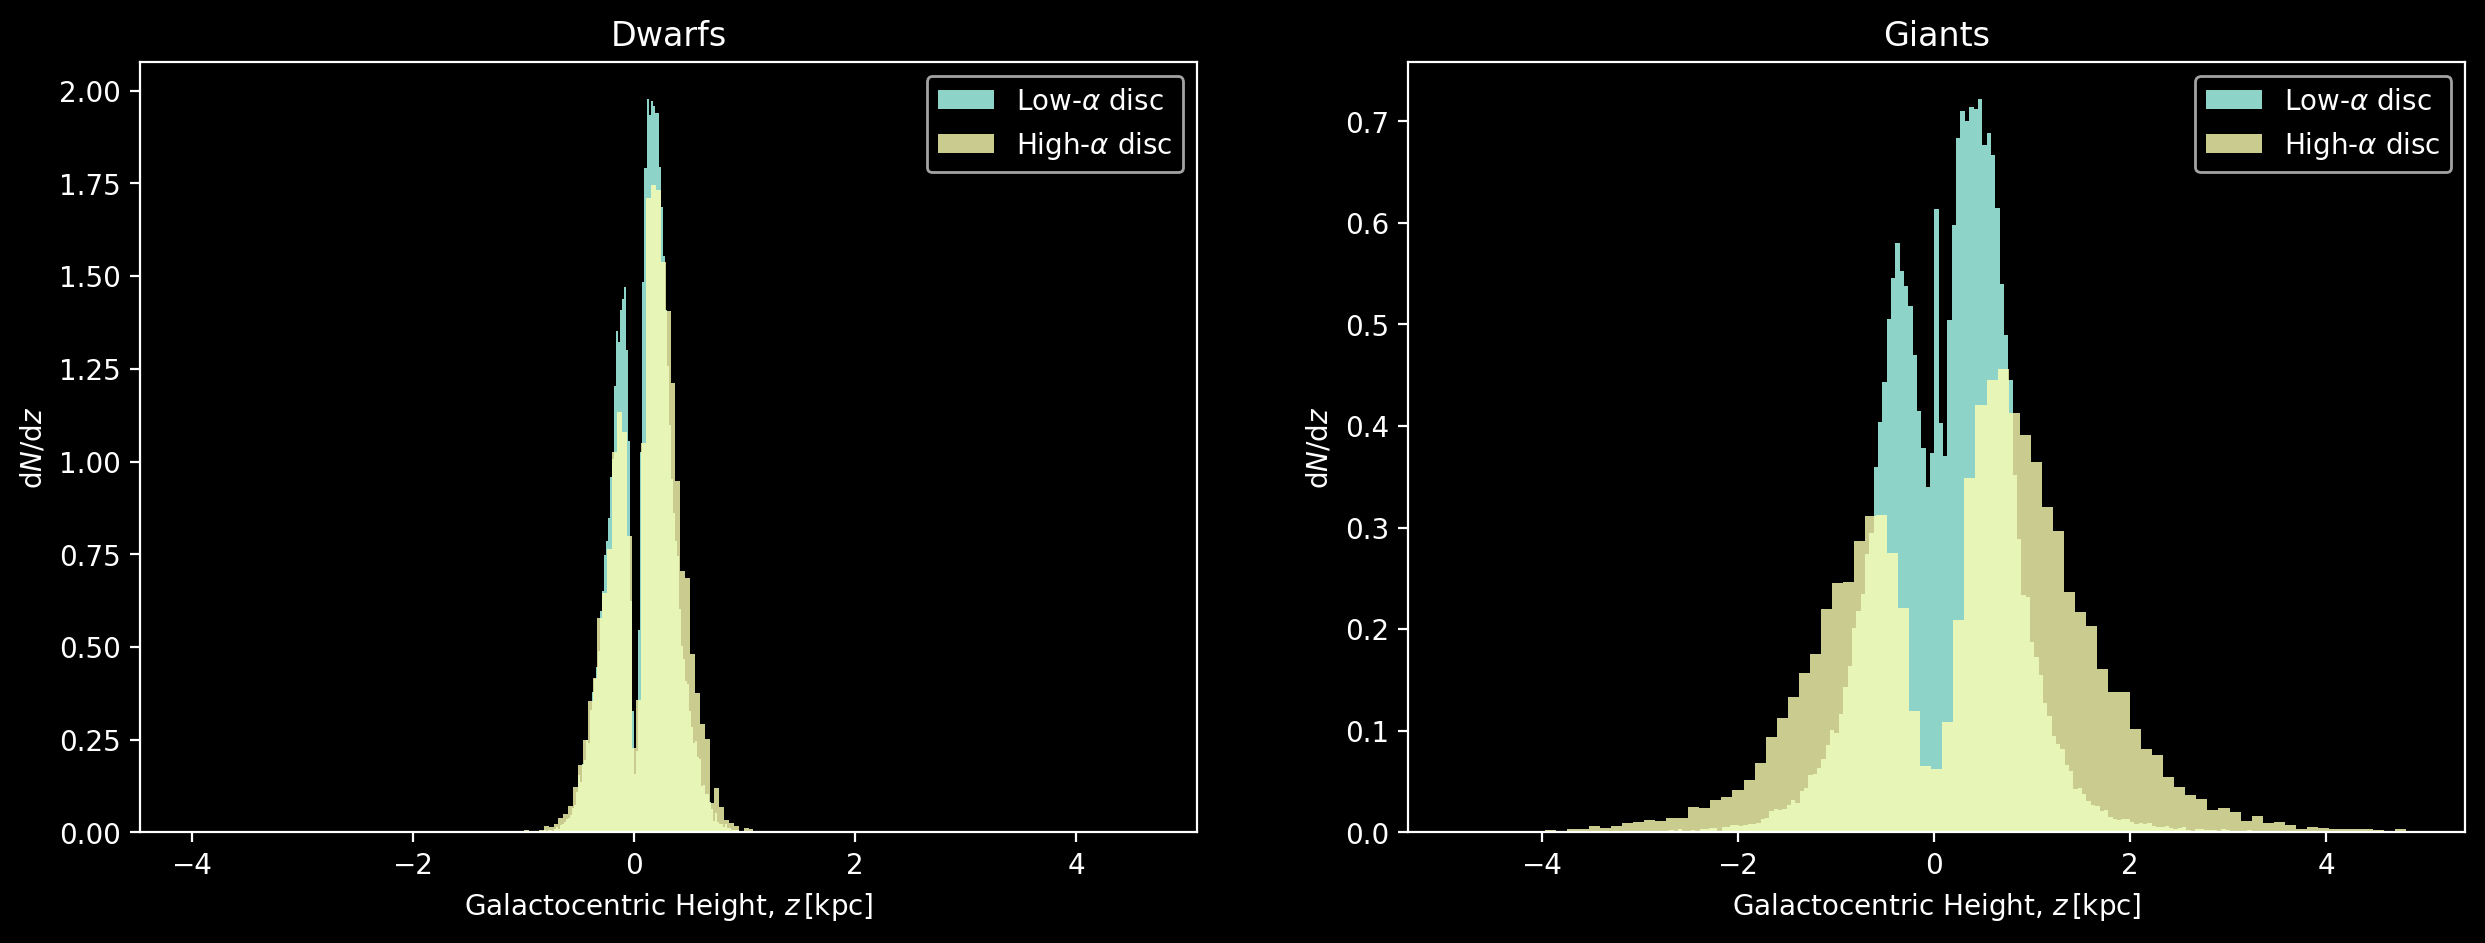

In [320]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, dgmask, title in zip(axes, [dwarfs, giants], ["Dwarfs", "Giants"]):
    for mask, colour, label in zip([low_alpha_mask, high_alpha_mask], ["C0", "C1"], [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        print(f'I find {(close_z & mask & dgmask).sum()} {title} in the {label}')
        ax.hist(coords.z.to(u.kpc).value[close_z & mask & dgmask], bins="fd", density=True, color=colour,
                alpha=0.8 if colour == "C1" else 1, zorder=-1, label=label);
    ax.set_title(title)

for ax in axes:
    ax.legend()
    ax.set_xlabel(r"Galactocentric Height, $z \, [\rm kpc]$")
    ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}z$")

plt.show()

As we expected from above, it seems like the dwarfs trace the thin disc well whilst the giants trace the thick disc better.

It is also important to note that extinction is at work here! Things near the midplane are going to have a lot more extinction and so we get dips near $z = 0$ in all of these plots.

### Fit scale heights

Now we can use `scipy` to fit Gaussians to each of the discs in order to estimate the scale heights.

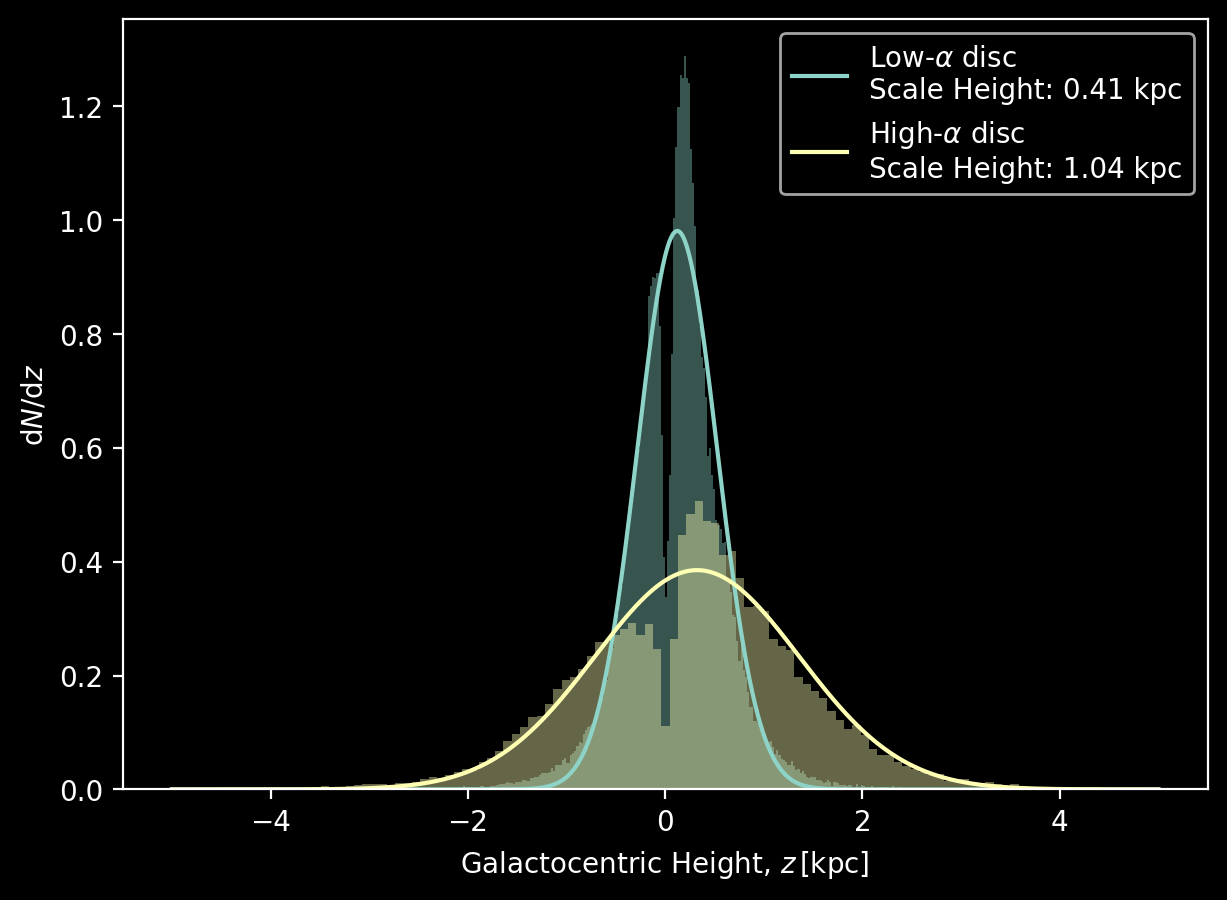

In [321]:
def gaussian(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

fig, ax = plt.subplots(figsize=(7, 5))

for mask, colour, label in zip([low_alpha_mask, high_alpha_mask], ["C0", "C1"], [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
    h, bins = np.histogram(coords.z.to(u.kpc).value[close_z & mask], bins="fd", density=True)
    bin_centres = (bins[1:] + bins[:-1]) / 2
    popt, pcov = curve_fit(gaussian, xdata=bin_centres, ydata=h)

    ax.hist(coords.z.to(u.kpc).value[close_z & mask], bins="fd", density=True, color=colour, alpha=0.4, zorder=-1);

    mu, sigma = popt
    z_range = np.linspace(-5, 5, 10000)
    ax.plot(z_range, gaussian(z_range, mu, sigma), color=colour, label=label + f"\nScale Height: {sigma:1.2f} kpc")

ax.legend()
ax.set_xlabel(r"Galactocentric Height, $z \, [\rm kpc]$")
ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}z$")

plt.show()

And given that we made many assumptions and didn't account for any selection effects we did a pretty reasonable job! Certainly the relative scale heights are about right and the absolute values are not far off :D

## 2.2: Mean metallicity in plane

How does metallicity vary as we meander our way across the galaxy? What about $[\alpha, {\rm M}]$? Let's find out!

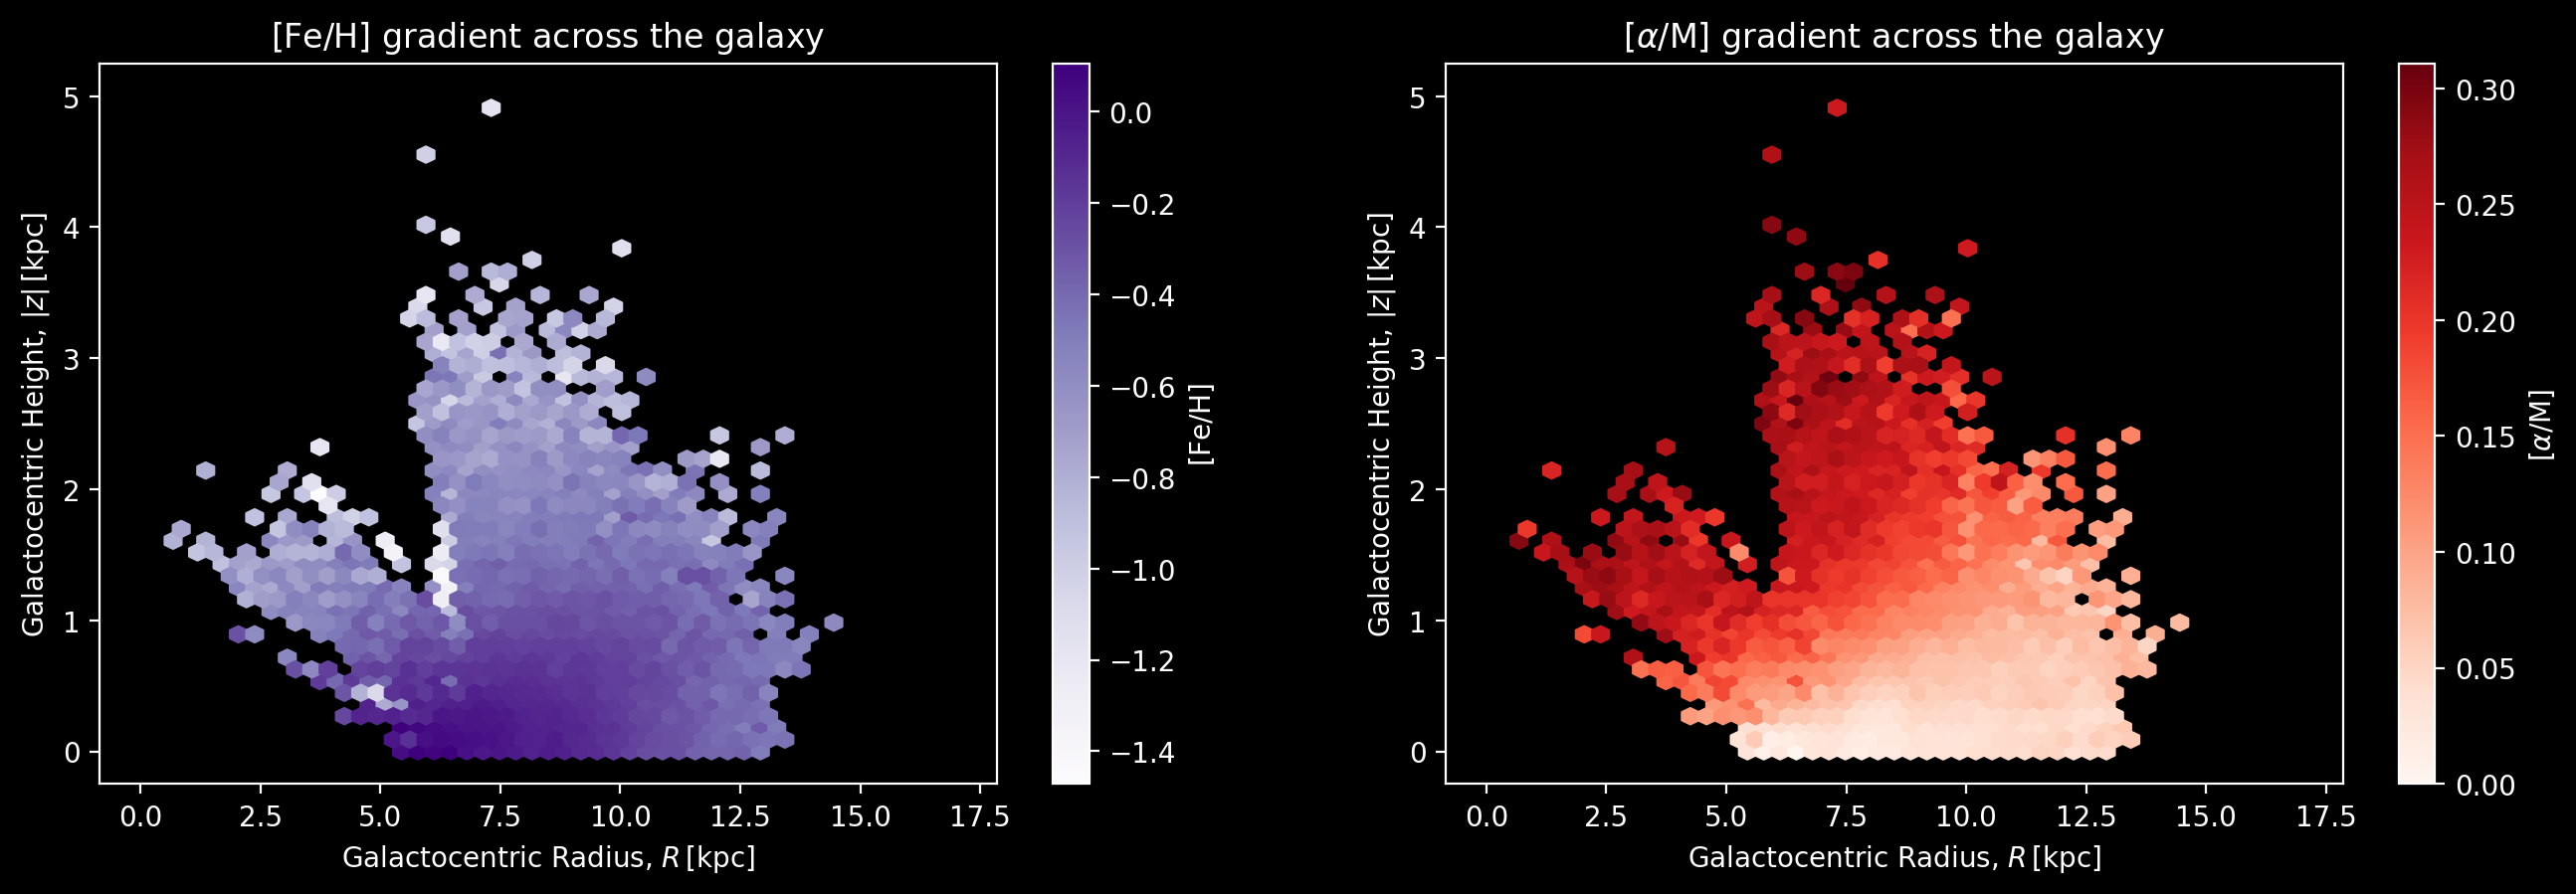

In [336]:
R = ((coords.x**2 + coords.y**2)**(0.5)).to(u.kpc).value

# get the mean as long as you've got some minimum number of stars
def reduce_func(x):
    if len(x) > 5:
        return np.mean(x)
    else:
        return np.nan

fig, axes = plt.subplots(1, 2, figsize=(16, 10 / 17 * 8))

for ax, cmap, C, label in zip(axes, ["Purples", "Reds"],
                              [df["FE_H"].values, df["ALPHA_M"].values],
                              [r"$\rm [Fe / H]$", r"$[\alpha / {\rm M}]$"]):
    hexbin = ax.hexbin(R, np.abs(coords.z.to(u.kpc).value),
                    C=C, reduce_C_function=reduce_func,
                    extent=(0, 17, 0, 5), cmap=cmap, gridsize=50)

    fig.colorbar(hexbin, label=label, ax=ax)

    ax.set_xlabel(r"Galactocentric Radius, $R \, [\rm kpc]$")
    ax.set_ylabel(r"Galactocentric Height, $|z| \, [\rm kpc]$")

    ax.set_title(f"{label} gradient across the galaxy")

plt.show()

Here I'm plotting 2D histograms of Galactocentric radius against absolute height above the midplane and showing the mean $\rm [Fe / H]$ and $[\alpha / {\rm M}]$ for each bin that hast least 5 stars.

We can see that as you increase in radius and/or height $\rm [Fe / H]$ decreases, where the trend is more abrupt in $z$ than in $R$. For $[\alpha / {\rm M}]$ there isn't much as much of a gradient across radius but there is a strong increase in $[\alpha / {\rm M}]$ as you move away from the midplane.

# Part 3: How the Sausage Gets Made
(An overambitious section title but someone needed to use it)

## 3.1: Grab the accreted stars
Jim said we can either do this using relative abundances or by kinematic. I figure that there's only one sensible response to this:

![](both.gif) onwards!

### The abundance way
For this we are going to copy our friends [Carrillo et al. 2022](https://arxiv.org/abs/2202.10416) and explore the $\rm ([Al/Fe], [Mg/Mn])$ plane. It took me an embarrassingly long time to work out why my plot looked dodgy until I realise I needed to subtract and not divide the Mg and Mn because they are in log space oops haha.

In [341]:
# get the values and work out the area containing the vast majority of stars
mg_mn = (df["MG_FE"] - df["MN_FE"]).values
al_fe = df["AL_FE"].values
lims = [0.2, 99.7]
extent = tuple(np.concatenate((np.percentile(df["AL_FE"], lims), np.percentile(mg_mn, lims))))

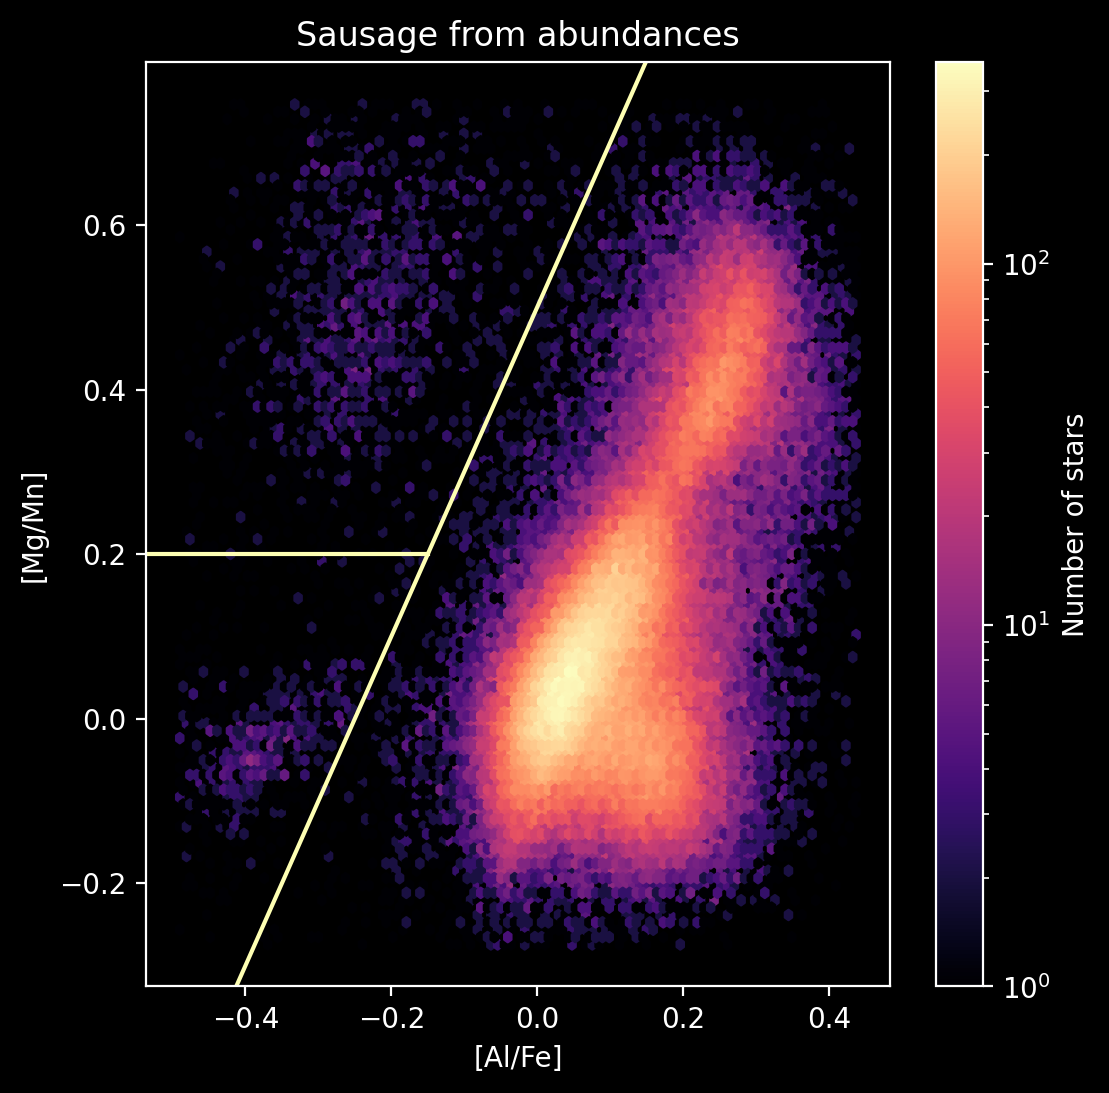

In [342]:
fig, ax = plt.subplots(figsize=(6, 6))

hexbin = ax.hexbin(al_fe, mg_mn, extent=extent, bins="log", cmap="magma")
fig.colorbar(hexbin, label="Number of stars")

xlims = ax.set_xlim()
ylims = ax.set_ylim()

al_fe_range = np.array([extent[0], extent[1]])
ax.plot(al_fe_range, al_fe_range * 2 + 0.5, color="C1")
ax.plot([xlims[0], (0.2 - 0.5) / 2], [0.2, 0.2], color="C1")

ax.set_xlim(xlims)
ax.set_ylim(ylims)

ax.set_xlabel("[Al/Fe]")
ax.set_ylabel("[Mg/Mn]")

ax.set_title("Sausage from abundances")

plt.show()

We can see a clear population separated to the left of the main galactic population and we can isolate this with some simple cuts indicated by the lines above.

<div style="color:red; font-size:50px">TODO ask Jim about two pops</div>

In [345]:
sausage_chemical = (al_fe * 2 + 0.5 < mg_mn) & (mg_mn > 0.2)
f'This gives us {sausage_chemical.sum()} stars in the sausage'

'This gives us 2760 stars in the sausage'

### The kinematic way

And now switching gears, let's try it from another angle and imitate these smart folks: [Fernandes et al. 2023](https://arxiv.org/abs/2301.01302). For this we're going to need to add the velocities in addition to the positions to the SkyCoord.

In [362]:
# expand the coords from before to include velocities as well as positions
coords = SkyCoord(ra=df["RA"].values * u.deg,
                  dec=df["DEC"].values * u.deg,
                  distance=df["GAIAEDR3_R_MED_GEO"].values * u.pc,
                  pm_ra_cosdec=df["GAIAEDR3_PMRA"].values * np.cos(df["DEC"].values * u.deg) * u.mas / u.yr,
                  pm_dec=df["GAIAEDR3_PMDEC"].values * u.mas / u.yr,
                  radial_velocity=df["GAIAEDR3_DR2_RADIAL_VELOCITY"].values * u.km / u.s,
                  frame="icrs").transform_to("galactocentric")

Now we can take these Galactocentric coordinates and load them into `Gala` as a `PhaseSpacePosition`.

In [364]:
w = PhaseSpacePosition(pos=[coords.x.to(u.kpc).value,
                            coords.y.to(u.kpc).value,
                            coords.z.to(u.kpc).value] * u.kpc,
                       vel=[coords.v_x.to(u.km / u.s).value,
                            coords.v_y.to(u.km / u.s).value,
                            coords.v_z.to(u.km / u.s).value] * u.km / u.s)

After this it is pretty simple to use `Gala` to get the energy and momentum (assuming `Gala`'s default `MilkyWayPotential`).

In [365]:
E = w.energy(MilkyWayPotential()).to(u.km**2 / u.s**2)
L_z = w.angular_momentum()[2, :].to(u.km * u.kpc / u.s)

And now we can just plot it up! My version seems to have the momentum sign flipped compared to the paper but I figured I'd leave it as is.

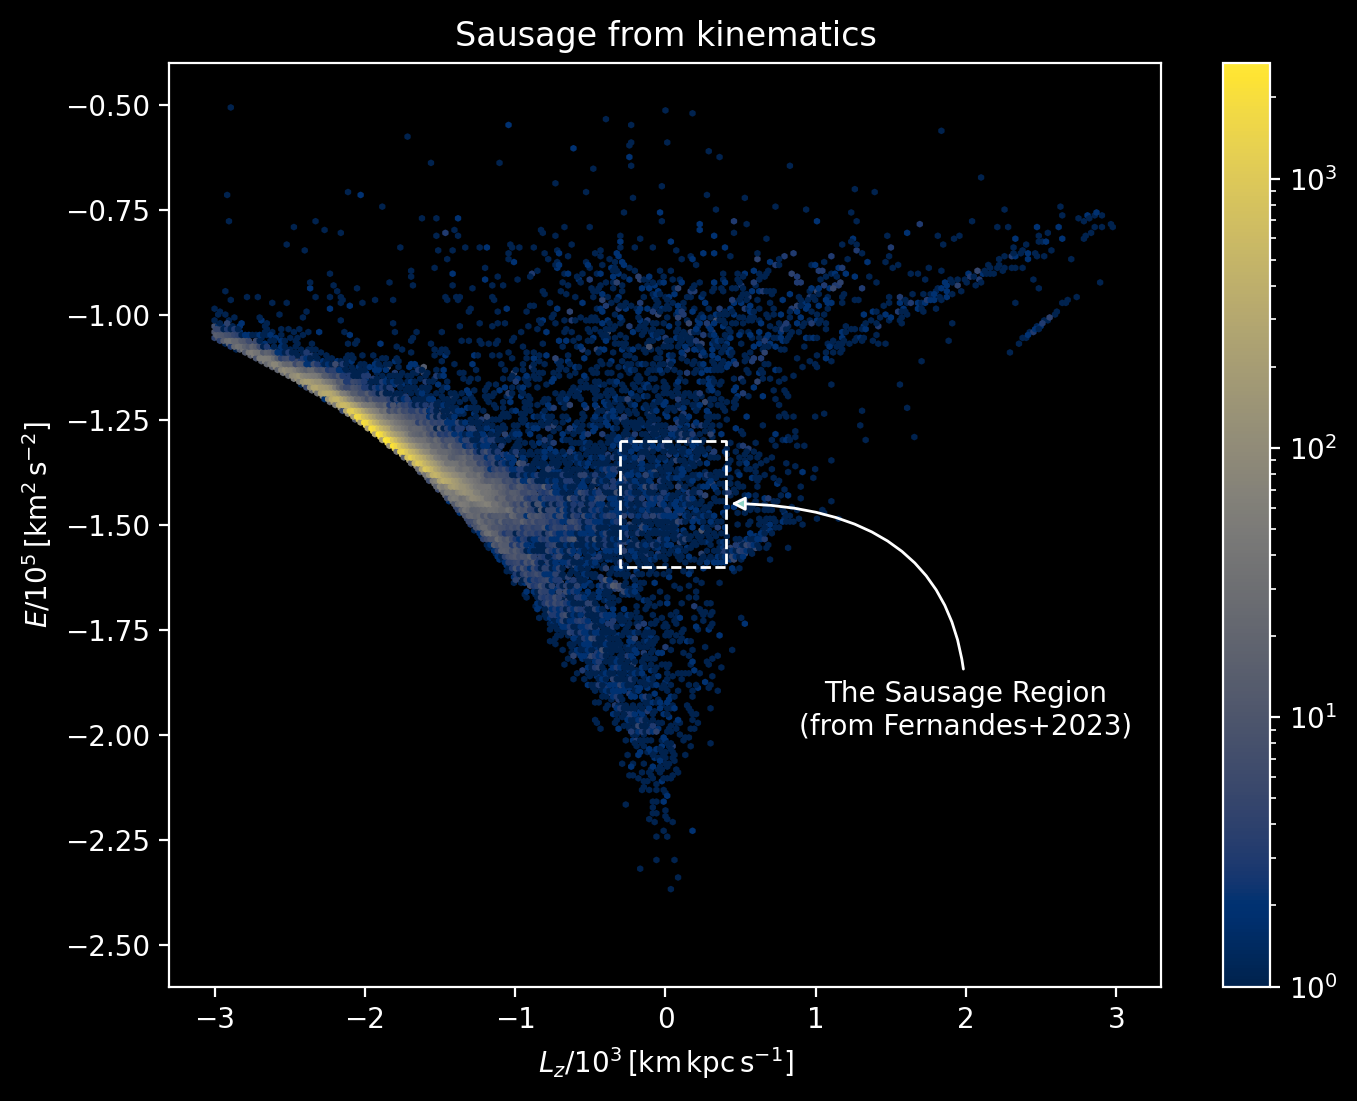

In [366]:
fig, ax = plt.subplots(figsize=(8, 6))

hexbin = ax.hexbin(L_z / 1e3, E / 1e5, extent=(-3, 3, -2.5, -0.5), bins="log", gridsize=250, cmap="cividis")
fig.colorbar(hexbin)

ax.fill_between([-0.3, 0.4], -1.6, -1.3, facecolor="none", linestyle="--")
ax.annotate("The Sausage Region\n(from Fernandes+2023)", xy=(0.4, -1.45), xytext=(2, -2), ha="center",
            arrowprops=dict(arrowstyle="-|>", connectionstyle="angle3"))

ax.set_xlabel(r"$L_z / 10^{3} \, [\rm km \, kpc \, s^{-1}]$")
ax.set_ylabel(r"$E / 10^{5} \, [\rm km^2 \, s^{-2}]$")

ax.set_title("Sausage from kinematics")

plt.show()

I've added on the rectangle region that the paper suggests for getting the Sausage out. We can use this as a mask in the same way as the previous subsection.

In [367]:
sausage_kin = ((E / 1e5 < -1.3 * u.km**2 / u.s**2)
               & (E / 1e5 > -1.6 * u.km**2 / u.s**2)
               & (L_z / 1e3 < 0.4 * u.km * u.kpc / u.s)
               & (L_z / 1e3 > -0.3 * u.km * u.kpc / u.s))
f'We find {sausage_kin.sum()} stars matching this mask'

'We find 1025 stars matching this mask'

## 3.2: Where is it?

### Wallerstein-Tinsley

Let's do scatter plots and make a separate panel for the masks separately and then the combination of the two.

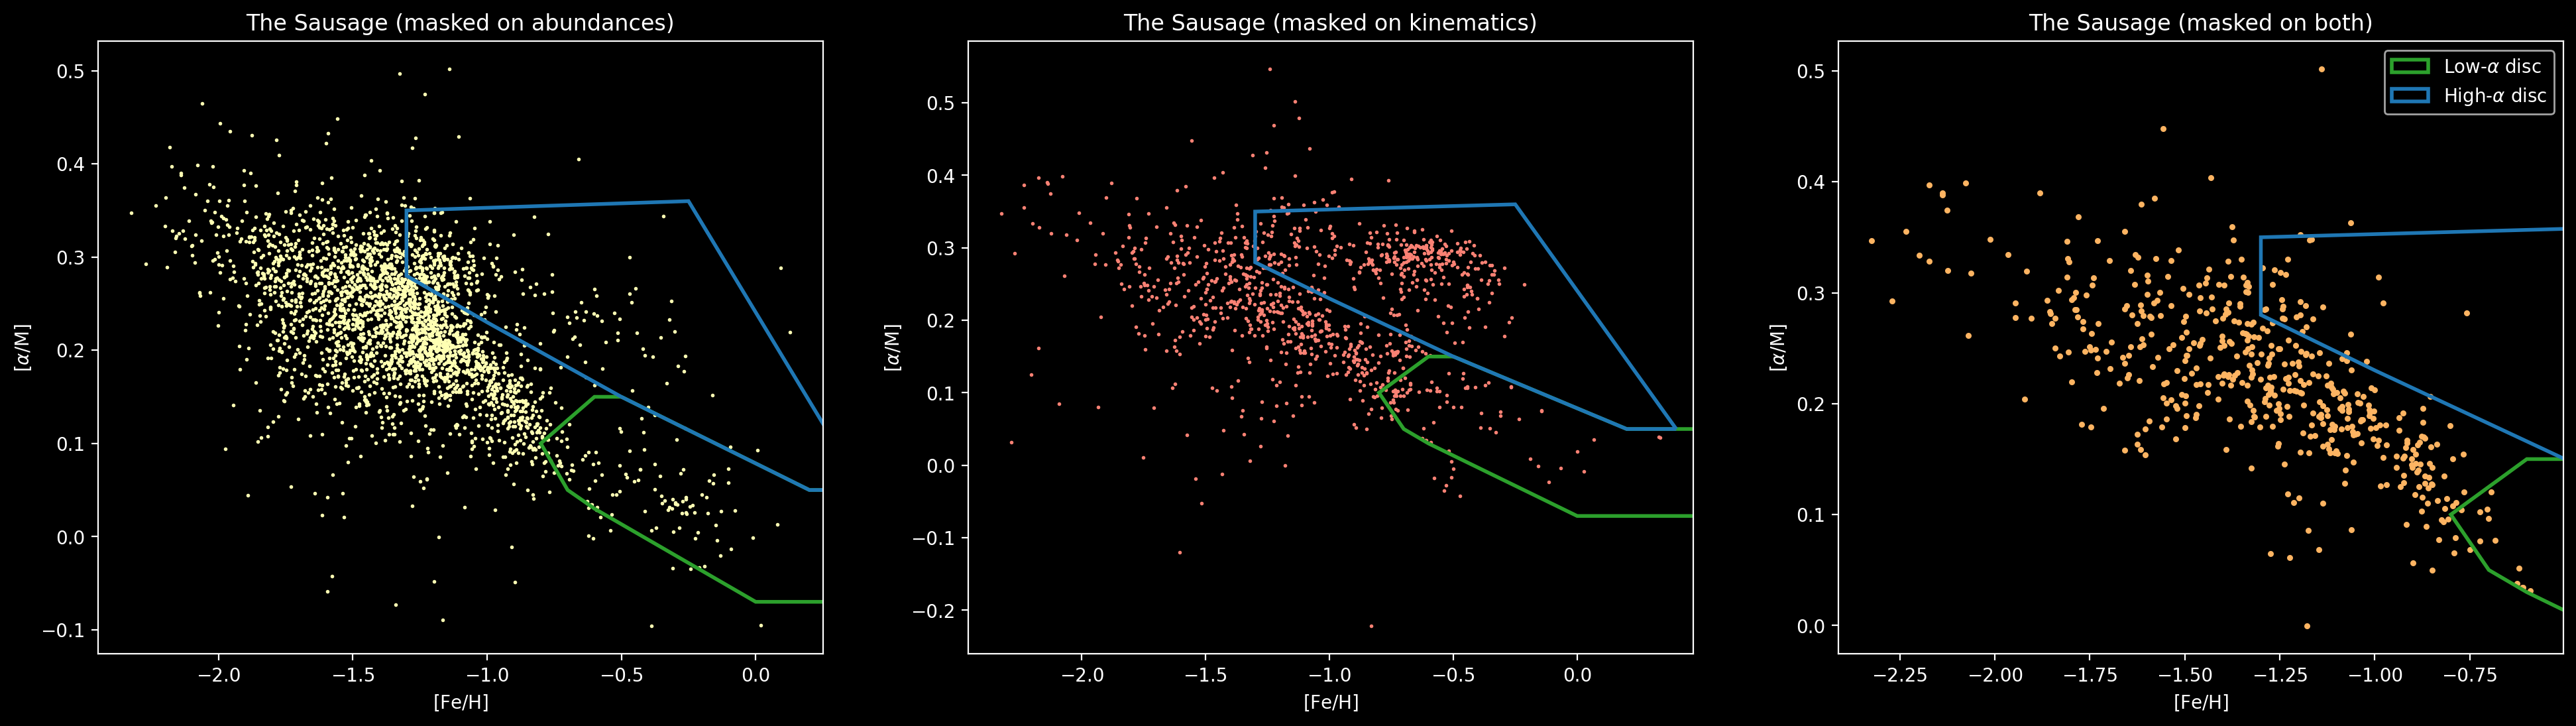

In [404]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for ax, mask, colour, what in zip(axes,
                                  [sausage_chemical, sausage_kin, sausage_chemical & sausage_kin],
                                  ["C1", "C3", "C5"],
                                  ["abundances", "kinematics", "both"]):
    ax.scatter(df["FE_H"][mask], df["ALPHA_M"][mask], s=5 if what == "both" else 1, color=colour)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                    ["tab:green", "tab:blue"],
                                    [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.set_title(f"The Sausage (masked on {what})")

ax.legend()

plt.show()

The overall population seems to span many different components and doesn't seem to be constrain to any of them. You can see differences in the methods, using abundances separates it more clearly from the discs whilst kinematics doesn't have the same effect. Taking the overlap of the two puts the population firmly outside of the discs, at lower metallicities.

### (R-Z) plane
Same again but this time we're talking about physical location!

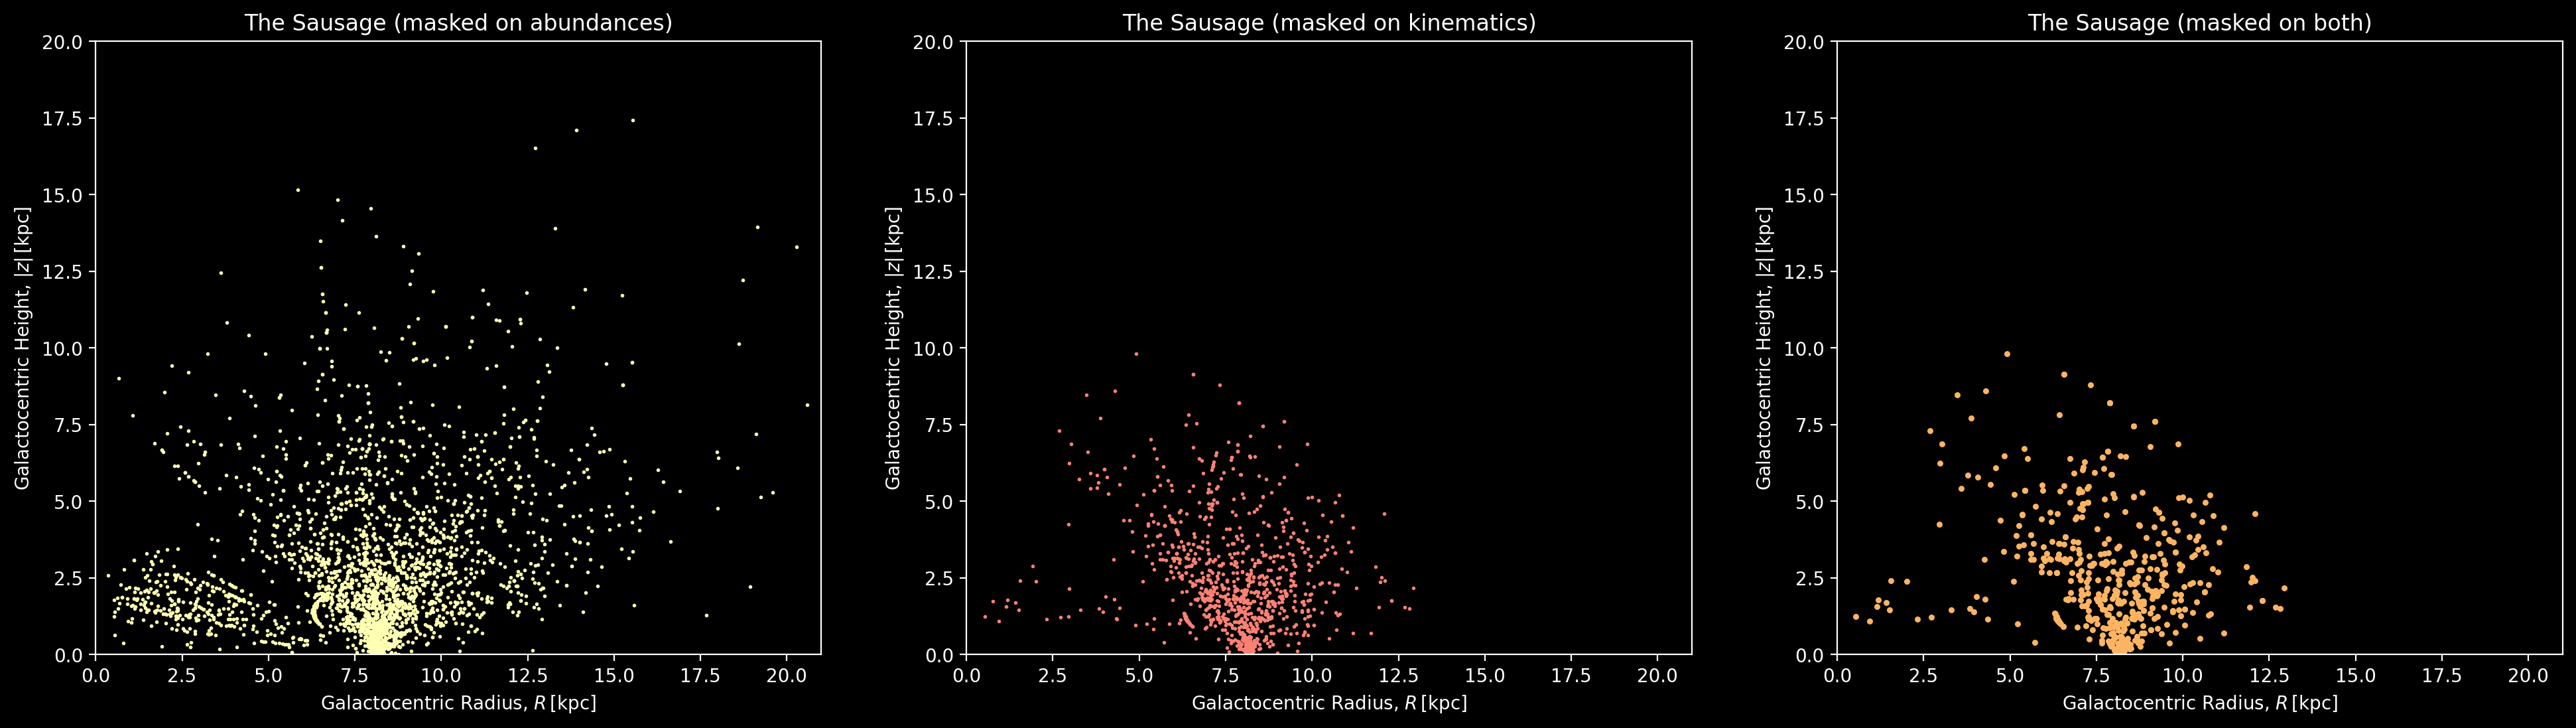

In [405]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for ax, mask, colour, what in zip(axes,
                                  [sausage_chemical, sausage_kin, sausage_chemical & sausage_kin],
                                  ["C1", "C3", "C5"],
                                  ["abundances", "kinematics", "both"]):
    ax.scatter(R[mask], np.abs(coords.z[mask].to(u.kpc)), s=5 if what == "both" else 1, color=colour)

    ax.set_xlabel(r"Galactocentric Radius, $R \, [\rm kpc]$")
    ax.set_ylabel(r"Galactocentric Height, $|z| \, [\rm kpc]$")

    ax.set_title(f"The Sausage (masked on {what})")

    ax.set_xlim(0, 21)
    ax.set_ylim(0, 20)

plt.show()

My first thought from this plot is how large the scale height of this population is, when using both masks it seems to span about the same range in height as in radius!! As before you can see differences in the methods, using abundances gives a wide range of locations across the galaxy but kinematics restricts it to be within a more constrained region.

And just because I'm curious, what happens if we look down onto the Galaxy

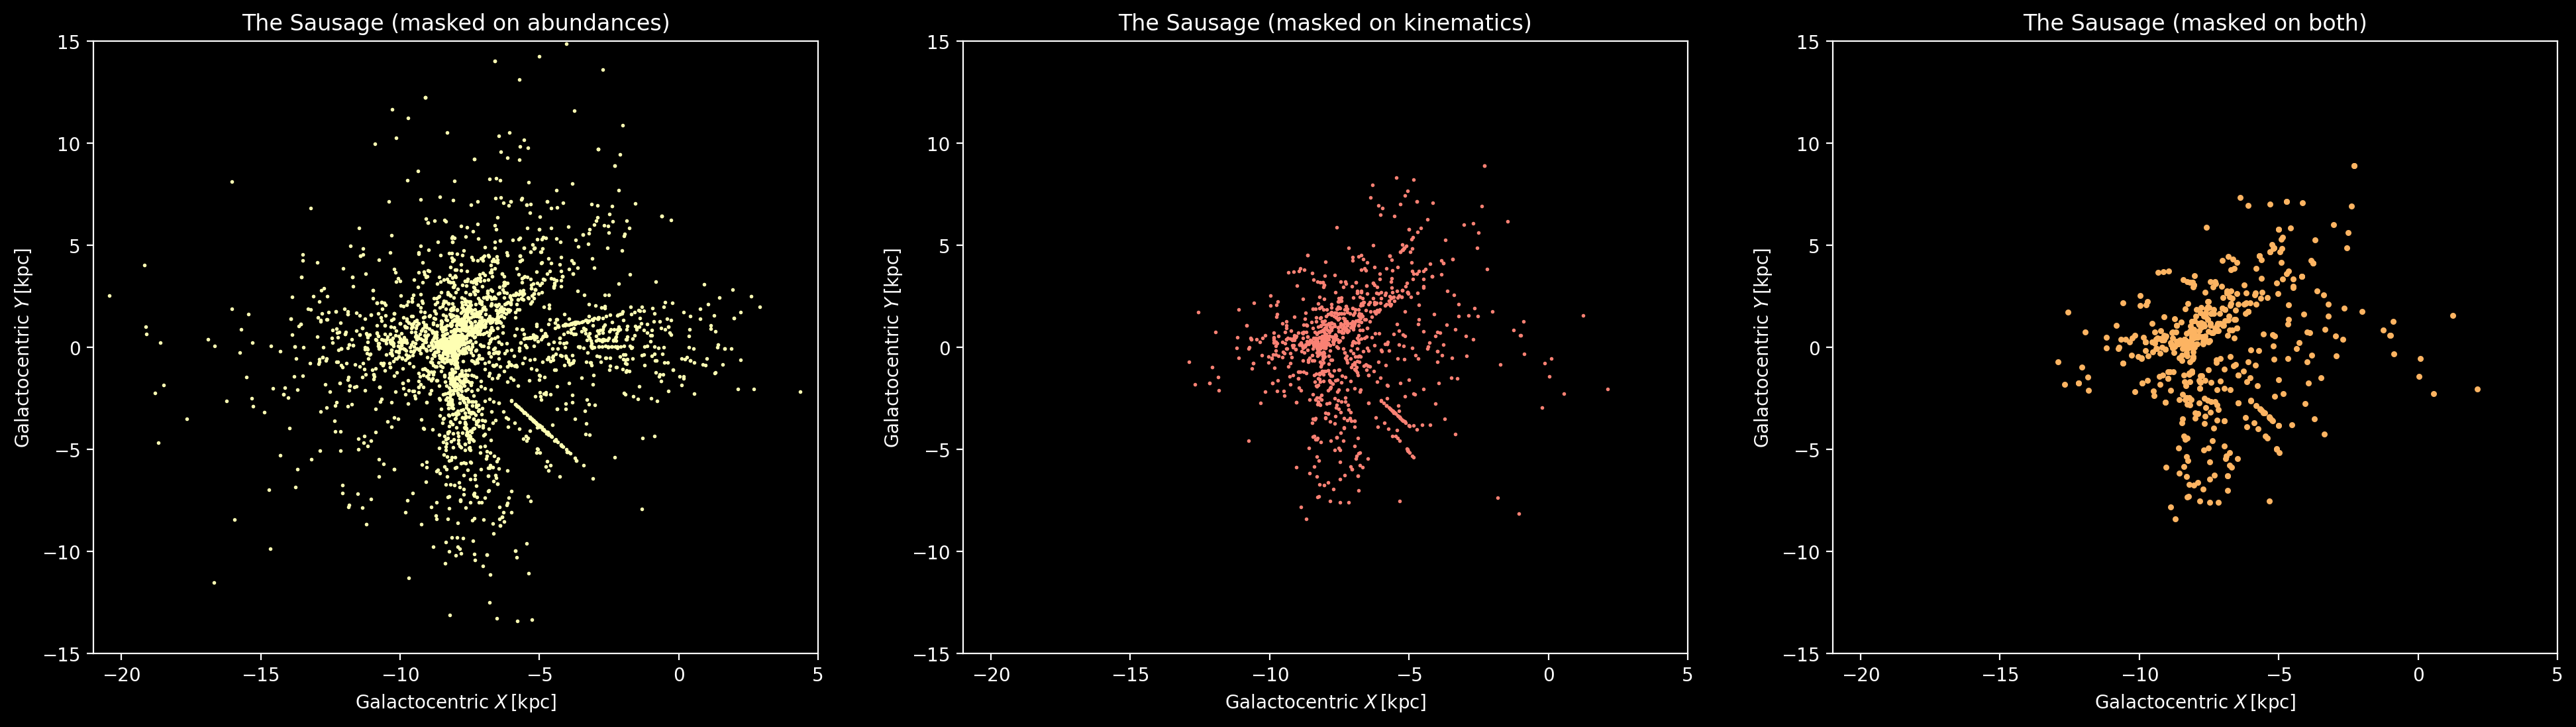

In [412]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for ax, mask, colour, what in zip(axes,
                                  [sausage_chemical, sausage_kin, sausage_chemical & sausage_kin],
                                  ["C1", "C3", "C5"],
                                  ["abundances", "kinematics", "both"]):
    ax.scatter(coords.x[mask].to(u.kpc), coords.y[mask].to(u.kpc), s=5 if what == "both" else 1, color=colour)

    ax.set_xlabel(r"Galactocentric $X \, [\rm kpc]$")
    ax.set_ylabel(r"Galactocentric $Y \, [\rm kpc]$")

    ax.set_title(f"The Sausage (masked on {what})")

    ax.set_xlim(-21, 5)
    ax.set_ylim(-15, 15)

plt.show()

Again no real restriction to any specific location (other than being near the Earth because that's easier to see) - this thing is everywhere!

## Part 3.3: Cool stuff

<div style="color:red; font-size:50px">TODO</div>